In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
#%matplotlib inline
plt.style.use('ggplot')

# Development Notes

## Method for extracting particles by weight

In [154]:
a = np.array([p for p in range(10)])
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [155]:
b = a / a.sum()
b

array([ 0.        ,  0.02222222,  0.04444444,  0.06666667,  0.08888889,
        0.11111111,  0.13333333,  0.15555556,  0.17777778,  0.2       ])

In [156]:
choices = np.random.multinomial(len(a), b)
choices

array([0, 0, 0, 0, 1, 2, 0, 0, 4, 3])

In [157]:
new_particle_list = []
for idx, count in enumerate(choices):
    while count > 0:
        new_particle_list.append(copy.copy(a[idx]))
        count -= 1
new_particle_list

[4, 5, 5, 8, 8, 8, 8, 9, 9, 9]

above implemented in `montecarlo_localization.mcl_update()`

# Unit Tests:

## Load and plot Wean Hall map

Test implementation

In [158]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)

## mcl.sample_list_by_weight()

In [159]:
toy_list = [l for l in 'abcd']
weights  = [10,5,1,0.1]

sample_list = [mcl.sample_list_by_weight(toy_list, weights) 
               for _ in range(100)]
print(sample_list[:10])
df = pd.DataFrame(sample_list)
print("\nValue Counts in first location:")
print(df[0].value_counts())

[['a', 'c', 'd', 'b'], ['b', 'a', 'a', 'a'], ['a', 'a', 'a', 'b'], ['a', 'a', 'a', 'a'], ['a', 'b', 'b', 'a'], ['a', 'a', 'a', 'b'], ['b', 'a', 'a', 'a'], ['b', 'a', 'b', 'b'], ['a', 'a', 'a', 'a'], ['b', 'a', 'a', 'b']]

Value Counts in first location:
a    61
b    31
c     8
Name: 0, dtype: int64


## mcl.robot_particle.sample_motion()

In [162]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata.head()

,type,ts,x,y,theta,xl,yl,thetal,1,2,...,171,172,173,174,175,176,177,178,179,180
0,1,0.025466,-94.234001,-139.953995,-1.342158,-88.567719,-164.303391,-1.342158,66,66,...,71,71,71,71,71,71,70,70,70,70
1,0,0.025863,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.079745,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.139828,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.200218,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
import time
fig, ax = plt.subplots(figsize=(10,10))
mcl.draw_map_state(global_map, ax=ax)
for _ in range(3):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True)
plt.show()

## Initialize valid particles uniformly on map

Particles are initialized uniformy over the entire 8000cm x 8000cm area with random heading, but are re-sampled if they end up in a grid cell which is not clear with high confidence (map value > 0.8).

In [164]:
particle_list = [mcl.robot_particle(global_map, sensor)
                 for _ in range(1000)]
mcl.draw_map_state(global_map, particle_list, rotate=True)
plt.show()

## Animation of moving particle

In [165]:
import matplotlib.animation as animation

sensor = mcl.laser_sensor()
particle = mcl.robot_particle(global_map, sensor)
fig, ax = plt.subplots()

def init():    
    mcl.draw_map_state(global_map, ax=ax)

def animate(message):
    #plt.cla()
    #mcl.draw_map_state(global_map, ax=ax)
    particle.sample_motion(message)
    mcl.plot_particle(particle, ax)

ani = animation.FuncAnimation(fig, animate, logdata.values[::50], init_func=init,
    interval=50, blit=False, repeat=False)

plt.show()

## Simple raycast in map

In [167]:
theta = 0
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')
plt.show()

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


### Raycasting each of 360 degrees around robot takes ~7.6ms per map location

In [168]:
%%timeit
for theta in np.linspace(0,2*np.pi, num=360):
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)

100 loops, best of 3: 7.34 ms per loop


## Pre-calculate (cache) range values in map

### Due to the static map, these values can be cached ahead of time (instead of re-computing for each particle)

In [179]:
%%time
def cache_map_ranges(theta_bins=120):
    slice_theta_rad = 2*np.pi/theta_bins
    slice_theta_deg = 360/theta_bins
    map_width, map_height = 800, 800

    coord_list = [(xidx, yidx) for yidx in range(map_height) 
                               for xidx in range(map_width)]
    range_array = np.zeros([map_width,map_height,theta_bins])
    raycast_degree_values = np.linspace(0,2*np.pi, num=theta_bins)
    # pre-calculate (cache) expected distance to wall for each theta bin, at each map location
    for xidx,yidx in coord_list:
        for idx, theta in enumerate(raycast_degree_values):
            _,_,dist = mcl.raycast_bresenham(xidx*10, yidx*10, theta, global_map, freespace_min_val=0.7)
            range_array[xidx,yidx,idx] = dist
    
    np.save('./data/range_array_{}bin'.format(theta_bins), range_array, allow_pickle=False)
    return range_array
raw_array = cache_map_ranges(theta_bins=120)  # Takes ~9 minutes with theta_bins=120 on core i5 laptop

Wall time: 9min 35s


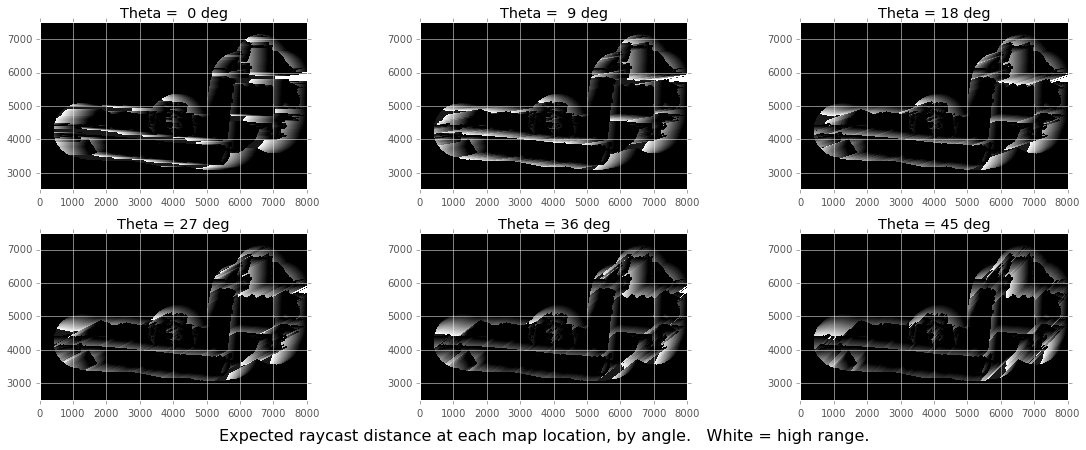

In [182]:
range_array = np.load('./data/range_array_40bin.npy')
slice_theta_deg = 360/40
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
for idx, ax in enumerate(fig.axes):
    ax.imshow(range_array[:,:,idx].T, cmap=plt.cm.gray, interpolation='nearest',
                  origin='lower', extent=(0,8000,0,8000), aspect='equal')
    ax.set_ylim(2500,7500)
    ax.set_xlim(0,8000)
    ax.set_title("Theta = {:2.0f} deg".format(idx*slice_theta_deg))
fig.tight_layout()
fig.suptitle("Expected raycast distance at each map location, by angle.   White = high range.", size=16, y=0)


## Test particle stochastic movement

### Very low error

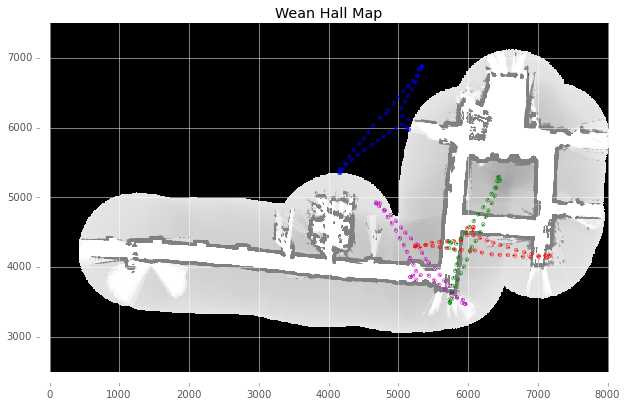

In [89]:
fwd_err_pct, theta_err_pct = 0.01, 0.01
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots(figsize=(10,10))
plt.hold(True)
mcl.draw_map_state(global_map, ax=ax)
for idx in range(4):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor,
                                  fwd_err_pct, theta_err_pct)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
plt.show()

### Theta error stdv = 10%

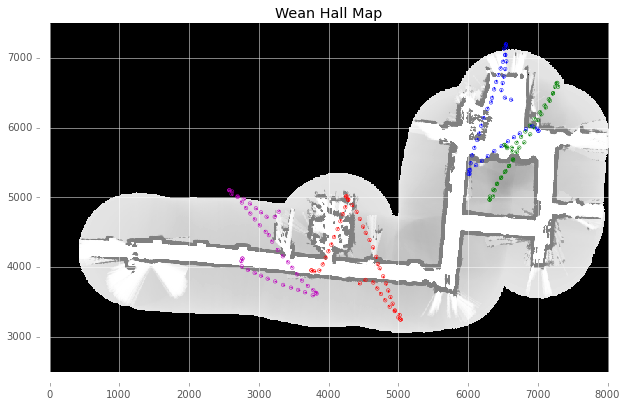

In [90]:
fwd_err_pct, theta_err_pct = 0.01, 0.1
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots(figsize=(10,10))
plt.hold(True)
mcl.draw_map_state(global_map, ax=ax)
for idx in range(4):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor,
                                  fwd_err_pct, theta_err_pct)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
plt.show()

### Forward error stdv = 30%

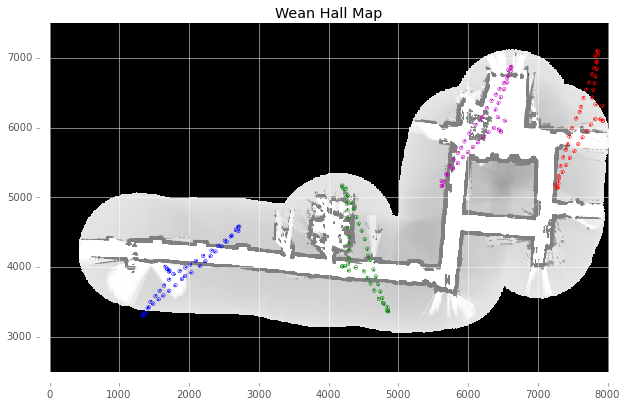

In [96]:
fwd_err_pct, theta_err_pct = 0.3, 0.01
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots(figsize=(10,10))
plt.hold(True)
mcl.draw_map_state(global_map, ax=ax)
for idx in range(4):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor,
                                  fwd_err_pct, theta_err_pct)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
plt.show()

In [84]:

np.random.normal()

-0.639764958713715

## Animate several moving particles

In [5]:
%%prun
import matplotlib.animation as animation

wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor()
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                                    sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(2000)]

class ParticleMap(object):
    def __init__(self, ax, global_map, particle_list):
        self.ax = ax
        self.global_map = global_map
        self.particle_list = particle_list
        #mcl.draw_map_state(global_map, particle_list, ax=self.ax)

    def update(self, message):
        plt.cla()
        self.particle_list = mcl.mcl_update(self.particle_list, message) # Update
        #mcl.draw_map_state(self.global_map, self.particle_list, self.ax)

fig, ax = plt.subplots()
pmap = ParticleMap(ax, wean_hall_map, particle_list)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, pmap.update, logdata.values[500::20], interval=50,
                              blit=False, repeat=False)


#plt.show()

In [23]:
%%prun
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor()
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                 sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(10000)]
for message in logdata.values:
    particle_list = mcl.mcl_update(particle_list, message)

In [24]:
mcl.draw_map_state(wean_hall_map, particle_list)
plt.show()

## Re-weight per sensor model

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


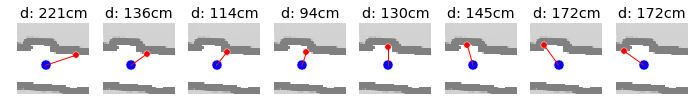

In [64]:
%matplotlib inline
theta = 0
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')
plt.show()

In [48]:
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
laser = mcl.laser_sensor()
particle = mcl.robot_particle(wean_hall_map, laser, sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
range_array_120 = np.load('./data/range_array_120bin.npy')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

In [49]:
particle.pose

array([  7.43055669e+03,   4.81945030e+03,   6.11012642e-01])

In [50]:
particle.update_measurement_likelihood(logdata.values[0])

0.11801005896244243

In [51]:
particle.weight

0.88198994103755757

In [52]:
rads = 2*np.pi
int(((rads / (2*np.pi)) * 120) % 120)

0

In [53]:
145 % 120

25

In [54]:
print(logdata.values[0,8:188:3])
rng1 = particle.global_map.ranges_180(2200, 4200, 2*np.pi/4)
print(rng1)
rng2 = particle.global_map.ranges_180(2200, 4200, 0)
print(rng2)

[  66.   66.   66.   66.   66.   67.   67.   67.   68.   67.  506.  481.
  445.  402.  379.  363.  358.  344.  332.  321.  298.  288.  282.  277.
  273.  268.  265.  263.  262.  261.  193.  189.  262.  191.  193.  272.
  277.  281.  288.  295.  303.  314.  325.  340.  372.   92.   89.   86.
   83.   81.   79.   77.   76.   74.   73.   72.   71.   71.   71.   70.]
[  870.           640.70273919   432.89721644   355.10561809   305.94117082
   259.61509971   211.896201     193.13207916   187.88294228   170.
   152.64337522   144.22205102   136.01470509   128.06248475   120.41594579
   113.13708499   106.30145813   100.           100.           108.16653826
   102.95630141    98.48857802    98.48857802    94.86832981    94.86832981
   104.40306509   133.41664064   131.52946438   130.3840481    130.3840481
   130.           130.3840481    141.42135624   141.42135624   143.17821063
   145.60219779   148.66068747   152.31546212   156.52475842   156.52475842
   161.24515497   166.43316977   17

In [286]:
distance.cosine(rng1, rng2)

0.16791591544382012

In [ ]:
%%prun
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor()
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                 sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(10000)]
for message in logdata.values:
    particle_list = mcl.mcl_update(particle_list, message)

In [55]:
%matplotlib qt
import matplotlib.animation as animation

wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor()
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                                    sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(1000)]

class ParticleMap(object):
    def __init__(self, ax, global_map, particle_list):
        self.ax = ax
        self.global_map = global_map
        self.particle_list = particle_list
        mcl.draw_map_state(global_map, particle_list, ax=self.ax)

    def update(self, message):
        self.particle_list = mcl.mcl_update(self.particle_list, message) # Update
        plt.cla()
        mcl.draw_map_state(self.global_map, self.particle_list, self.ax)

fig, ax = plt.subplots()
pmap = ParticleMap(ax, wean_hall_map, particle_list)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, pmap.update, logdata.values[::20], interval=50,
                              blit=False, repeat=False)


plt.show()

In [46]:
%%prun
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

laser = mcl.laser_sensor()
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                 sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(1000)]
for message in logdata.values:
    particle_list = mcl.mcl_update(particle_list, message)

```
 135105098 function calls (135103848 primitive calls) in 415.633 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   905268  179.985    0.000  179.985    0.000 montecarlo_localization.py:85(<listcomp>)
 54316080   59.674    0.000   59.674    0.000 montecarlo_localization.py:89(rads_to_bucket_id)
  2718627   26.278    0.000   32.328    0.000 montecarlo_localization.py:165(new_pose_from_log_delta)
   905268   26.027    0.000  352.293    0.000 montecarlo_localization.py:136(update_measurement_likelihood)
   905268   18.846    0.000   78.519    0.000 montecarlo_localization.py:99(<listcomp>)
9188368/9188365   13.292    0.000   13.292    0.000 {built-in method numpy.core.multiarray.array}
  2849599   11.917    0.000   11.917    0.000 montecarlo_localization.py:192(position_valid)
  1810536   10.112    0.000   15.713    0.000 blas.py:221(_get_funcs)
```

In [ ]:
mcl.draw_map_state(wean_hall_map, particle_list)
plt.show()